# 07 Align the spine

We need to make sure that all the fruits are standing upright before further modeling
- Some spine tissue is very irregular by the sides (flaps between flesh wedges)
- In such case, it is better to erode the spine to remove this extraneous flaps and keep just a bare column
- The column is aligned via PCA
- Since the sign of the eigenvectors is arbitrary when computed, final visual inspection is done to ensure that the fruit is standing on its base.

The alignment is stored as a rotation 3x3 matrix `vh` for each fruit.

In [1]:
import numpy as np
import pandas as pd
import glob
import os

import warnings
warnings.filterwarnings( "ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import tifffile as tf

from scipy import ndimage

import citrus_utils as vitaminC

In [2]:
tissue_src = '../data/tissue/'
bnames = [os.path.split(x)[-1] for x in sorted(glob.glob(tissue_src + 'WR*'))]
for i in range(len(bnames)):
    print(i, '\t', bnames[i])

0 	 WR05_CRC3605_18B-19-5
1 	 WR18_CRC2863_12A-39-9


In [3]:
footpoints = 'geocentric'
oil_src = '../data/oil/'
oil_dst = '../data/glands/'
bname = bnames[0]
L = 3

lname = 'L{:02d}'.format(L)
src = oil_src + bname + '/' + lname + '/' 

savefig = True
dst = '../data/spine/'
if not os.path.isdir(dst):
    os.makedirs(dst)

spinename = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_spine.tif'
exoname = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_exocarp.tif'
print(spinename)

../data/tissue/WR05_CRC3605_18B-19-5/L03/WR05_CRC3605_18B-19-5_L03_spine.tif


In [4]:
exo = tf.imread(exoname)
spine = tf.imread(spinename)
scoords = np.asarray(np.nonzero(spine))

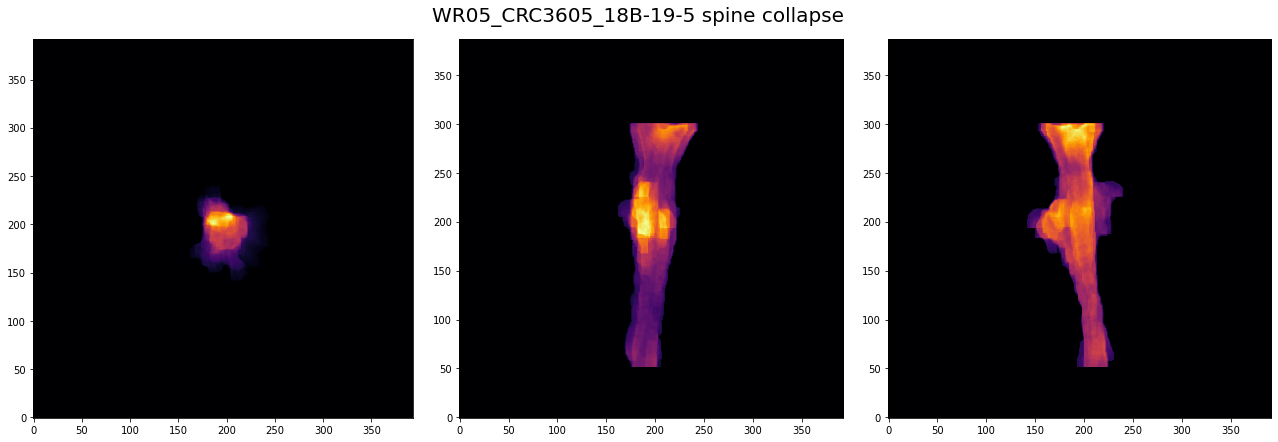

In [5]:
snaps = vitaminC.collapse_dimensions(spine)
vitaminC.plot_collapse_dimensions(snaps, bname, 'spine')

Plot the original exocarp to get a sense if the fruit is standing upright as it is.
- This one, `WR05` is almost upright

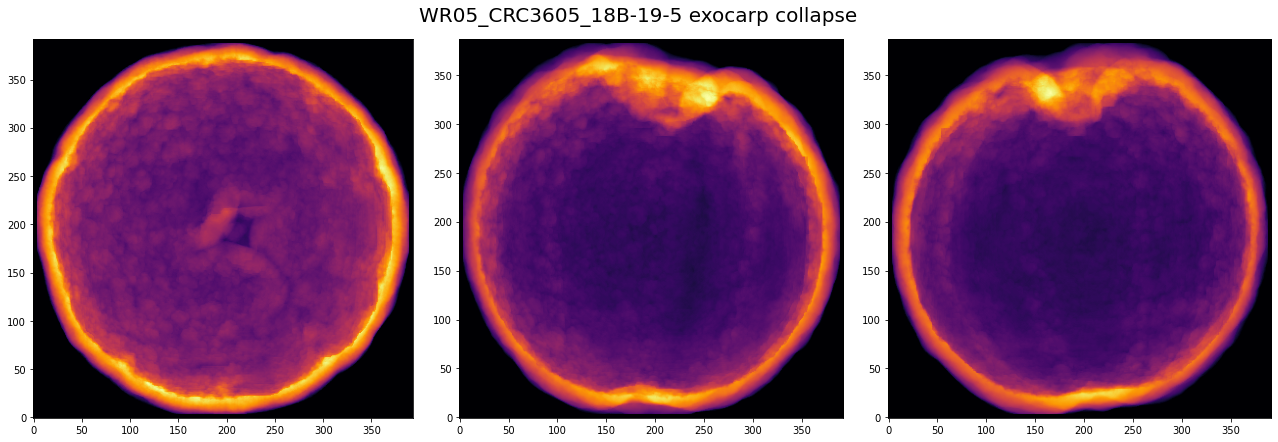

In [6]:
snaps = vitaminC.collapse_dimensions(exo)
vitaminC.plot_collapse_dimensions(snaps, bname, 'exocarp')

In [8]:
sz = 3
espine = ndimage.grey_erosion(spine, size=(sz,sz,sz))
tspine = vitaminC.get_largest_element(espine)

1 components
[314429]


- Erorded spine
- The `x,y,z` coordinates have been aligned via PCA
- The plot confirms that the spine is standing upright

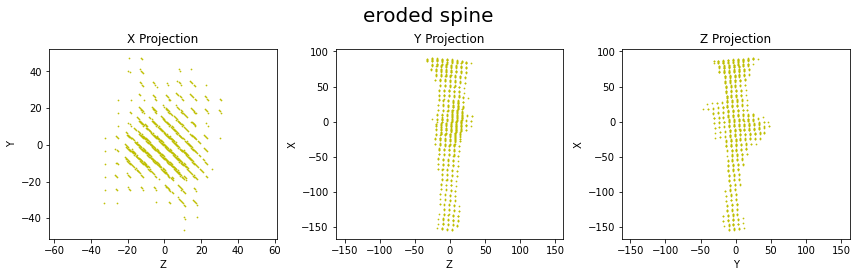

In [9]:
vh = vitaminC.spine_based_alignment(tspine, 'eroded spine', savefig=False, dst=dst)

If the spine were to be standing upside down, we can flip the rotation by doing
```
vh[0] = -vh[0]
```

Save the rotation matrix `vh` in the same folder as the spine scan

In [12]:
filename = tissue_src + bname + '/' + lname + '/' + bname + '_' + lname + '_vh_alignment.csv'
np.savetxt(filename, vh, delimiter=',')

### Verify that `vh` is the right rotation

- Rotate the oil gland tissues and check if the fruit looks standing upright

In [16]:
filename = src + bname + '_glands.tif'
img = tf.imread(filename)
centers = np.asarray(np.nonzero(img))

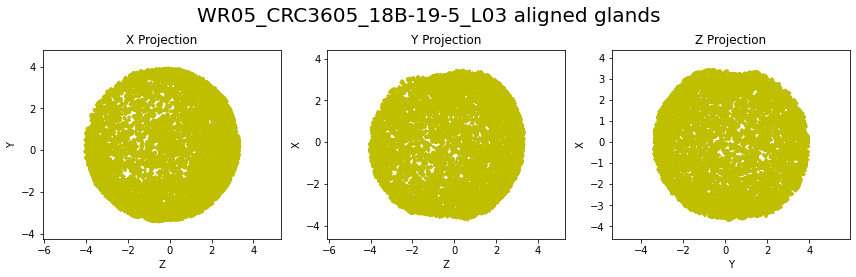

In [17]:
glands = np.matmul(centers.T, np.transpose(vh))
centerby = np.mean(glands, axis = 0)
scaleby = .5*np.std(glands[:,0])

glands = (glands - centerby)/scaleby

title = bname + '_' + lname + ' aligned glands'
vitaminC.plot_3Dprojections(glands, title=title, writefig=False, dst=dst)